## Lyft perception challenge

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import pandas as pd
import keras


IMG_SIZE = (320,800,3) # This is also the original image size
BBOX_SIZE = (64, 64)
NUM_TO_SHOW = 10
LABEL_MAP = {
    0: None,
    1: "Buildings",
    2: "Fences",
    3: "Other",
    4: "Pedestrians",
    5: "Poles",
    6: "RoadLines",
    7: "Roads",
    8: "Sidewalks",
    9: "Vegetation",
    10: "Vehicles",
    11: "Walls",
    12: "TrafficSigns"
}
PREFIX = ""
REPORT_FOLDER = "./report/"
DATA_X_FOLDER = "./train/*train/CameraRGB/"
DATA_Y_FOLDER = "./train/*train/CameraSeg/"
NUM_TO_SHOW = 10
START_Y = 200
END_Y = 520



/Users/Jerry/miniconda2/envs/carnd-term1-upgrade/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/Jerry/miniconda2/envs/carnd-term1-upgrade/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## Helper functions
we preprocess the labels to remove the hood of the car present in all labeled images

In [2]:
def preprocess_labels(label_image):
    labels_new = np.copy(label_image)
    # Identify lane marking pixels (label is 6)
    lane_marking_pixels = (label_image[:,:,0] == 6).nonzero()
    # print(lane_marking_pixels)
    # Set lane marking pixels to road (label is 7)
    labels_new[lane_marking_pixels] = 7

    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == 10).nonzero()
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices],
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    # Return the preprocessed label image 
    return labels_new

# Convert to binary, single-channel image
def relabel(label_image, target_label):
    labels_new = np.zeros_like(label_image)
    target_pixels = (label_image[:,:,0] == target_label).nonzero()
    labels_new[target_pixels] = 1
    return labels_new

## Dataset Exploration

I downloaded Carla simulator, ran the python client for 13 episodes, each time with a different weather setting, and repeated this with town02 map. Each episode yields 300 images, for a total of 13 * 2 * 300 more images. Furthermore, thanks to @chinkiat on #Lyft-Challenge slack channel, for sharing his dataset of 1000 more images with cars and pedestrians, which I included in the training set.

Below is a visualization of some of the images.

10394 training images , 10394 target images
Image size is (600, 800, 3)
There are 13 class labels before preprocessing.


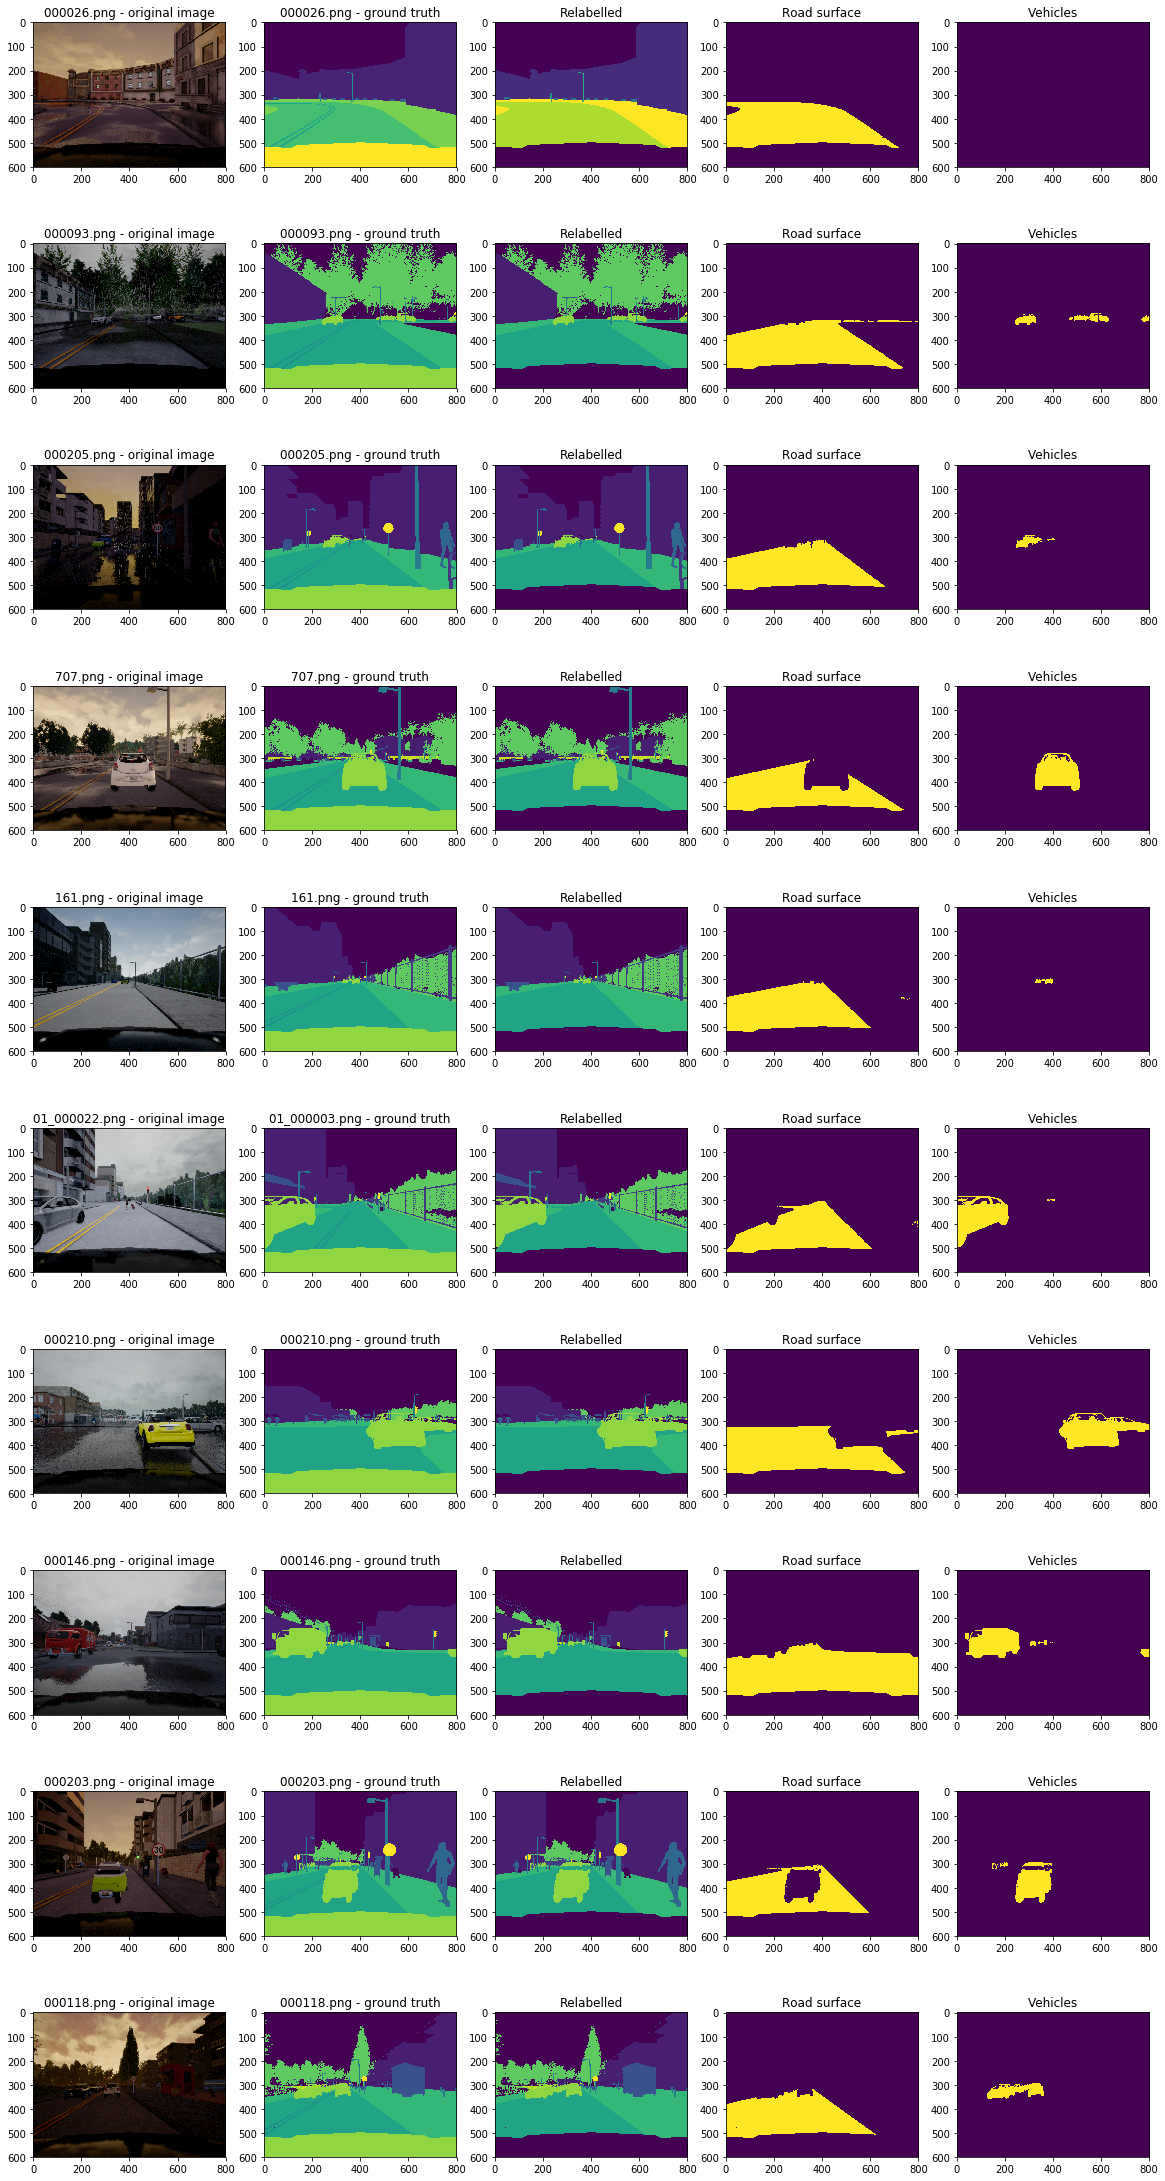

In [3]:
X_paths = glob.glob(DATA_X_FOLDER + "*.png")
y_paths = glob.glob(DATA_Y_FOLDER + "*.png")
print("%d training images , %d target images" % (len(X_paths), len(y_paths)))
print("Image size is (600, 800, 3)")
print("There are %d class labels before preprocessing." % (len(LABEL_MAP)))
fig, axes = plt.subplots(NUM_TO_SHOW, 5, figsize=(20, NUM_TO_SHOW*4))
indices = (np.random.random(NUM_TO_SHOW) * len(X_paths)).astype(np.int32)
for idx, indice in enumerate(indices):
    xpath = X_paths[indice]
    ypath = y_paths[indice]
    x_img = mpimg.imread(xpath)
    y_img = (mpimg.imread(ypath) * 255).astype(np.uint8)
    axes[idx,0].imshow(x_img)
    axes[idx,0].set_title(xpath.split("/")[-1] + " - original image")
    axes[idx,1].imshow(y_img[:,:,0])
    axes[idx,1].set_title(ypath.split("/")[-1] + " - ground truth")
    # Preprocess labels
    labels_new = preprocess_labels(y_img)
    axes[idx,2].imshow(labels_new[:,:,0])
    axes[idx,2].set_title("Relabelled")
    
    road_surface = relabel(labels_new, 7)
    axes[idx,3].imshow(road_surface[:,:,0])
    axes[idx,3].set_title("Road surface")
    
    vehicles= relabel(labels_new, 10)
    axes[idx,4].imshow(vehicles[:,:,0])
    axes[idx,4].set_title("Vehicles")
plt.savefig(REPORT_FOLDER + "training_dataset_visualization")

## Augmentation

I tried 3 basic augmentations - adjusting brightness, random translation in the x and y directions and flipping the image about the vertical axis. The last augmentation would help in situations where the vehicle is turning from left to right and the neural network would be able to learn the symmetric scenario of turning right to left.

I tried other techniques like taking the bounding boxes of head-on vehicles on the opposite lane, as well as turning vehicles, and blowing them up to the full image size, the rationale being 1) those are rare scenarios in an already imbalanced dataset of way more pixels classified as road rather than vehicles, 2) the size of vehicles is inversely related to number of vehicles - for every image, you can squeeze in more smaller vehicles further away from the camera while you can only fit a few large vehicles the closer they appear to the camera. This was my attempt at balancing the distribution of classes in the dataset, however, the network performed worst, thus I did not continue with this plan.

In [4]:
from scipy.ndimage.measurements import label

### Augmentation functions and related helper functions

def augment_brightness(imageX, imageY):
    ### Augment brightness
    random_bright = .25+np.random.uniform()

    image1 = cv2.cvtColor(imageX,cv2.COLOR_RGB2HSV)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    
    image2 = cv2.cvtColor(imageY,cv2.COLOR_RGB2HSV)
    image2[:,:,2] = image2[:,:,2]*random_bright
    image2 = cv2.cvtColor(image2,cv2.COLOR_HSV2RGB)
    return image1, image2

def trans_image(imageX, imageY, trans_range):
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    
    rows,cols,channels = imageX.shape
    imageX_tr = cv2.warpAffine(imageX,Trans_M,(cols,rows))
    imageY_tr = cv2.warpAffine(imageY,Trans_M,(cols,rows))
    return imageX_tr, imageY_tr


def scale_image(imageX, imageY, scale_range):
    # Scale augmentation
    original_shape = imageX.shape
    halfy = original_shape[1] // 2
    halfx = original_shape[0] // 2
    scale_factor = np.random.uniform(1, scale_range)
    new_shape = (int(original_shape[1] * scale_factor), int(original_shape[0] * scale_factor))
    
    imgX = cv2.resize(imageX, new_shape)
    imgY = cv2.resize(imageY, new_shape)
    if scale_factor > 1:
        # BE CAREFUL! new_shape is (cols, rows) as required by opencv resize
        startx = (new_shape[1] // 2) - halfx
        endx = (new_shape[1] // 2) + halfx
        starty = (new_shape[0] // 2) - halfy
        endy = (new_shape[0] // 2) + halfy
        return imgX[startx:endx, starty:endy, :], imgY[startx:endx, starty:endy, :]
    else:
        return imgX, imgY


# rescale to bounding box of all isolated instances of the target label
# Does not preserve scale in x and y directions
def rescale_to_bb(imageX, imageY):
    original_shape = imageX.shape
    vehicle_pixels = np.where(imageY == 1)
    if len(vehicle_pixels[0]) > 0 and len(vehicle_pixels[1] > 0):
        xmin = min(vehicle_pixels[0])
        xmax = max(vehicle_pixels[0])
        ymin = min(vehicle_pixels[1])
        ymax = max(vehicle_pixels[1])
        resizedX = cv2.resize(imageX[xmin:xmax, ymin:ymax], (original_shape[1], original_shape[0]))
        resizedY = cv2.resize(imageY[xmin:xmax, ymin:ymax], (original_shape[1], original_shape[0]))
        return resizedX, resizedY
    else:
        return imageX, imageY

def flip_lr(imageX, imageY):
    flipped_imageX = cv2.flip(imageX, 1)
    flipped_imageY = cv2.flip(imageY, 1)
    return flipped_imageX, flipped_imageY

# rescale to bounding box given
# Does not preserve x:y aspect ratio
def rescale_to_bb_given(imageX, imageY, bb):
    original_shape = imageX.shape
    cropped_shape = (320, 800)
    ul, lr = bb
    xmin, ymin = ul
    xmax, ymax = lr
    resizedX = cv2.resize(imageX[ymin:ymax, xmin:xmax], (cropped_shape[1], cropped_shape[0]))
    resizedY = cv2.resize(imageY[ymin:ymax, xmin:xmax], (cropped_shape[1], cropped_shape[0]))
    return resizedX, resizedY

MIN_BB_SIZE_X = 10
MIN_BB_SIZE_Y = 10
def get_bboxes(imageY):
    bboxes = []
    labels = label(imageY)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        min_x = np.min(nonzerox)
        min_y = np.min(nonzeroy)
        max_x = np.max(nonzerox)
        max_y = np.max(nonzeroy)
        if (max_x - min_x > MIN_BB_SIZE_X) and (max_y - min_y > MIN_BB_SIZE_Y):
            bboxes.append(((min_x, min_y), (max_x, max_y)))
    return bboxes

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        min_x = np.min(nonzerox)
        min_y = np.min(nonzeroy)
        max_x = np.max(nonzerox)
        max_y = np.max(nonzeroy)
        bbox = ((min_x, min_y), (max_x, max_y))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


def is_vehicle_sideways(image, bb):
    if bb is None: return False
    else:
        ul, lr = bb
        xmin, ymin = ul
        xmax, ymax = lr
        # print((ymax - ymin) / (1.0 * (xmax - xmin)))
        if (ymax - ymin) / (1.0 * (xmax - xmin)) < 0.40: 
        # if height is lesser than length of car
            return True
        else:
            return False

def is_vehicle_headon(image, bb):
    if bb is None: return False
    else:
        grad = -image.shape[0]/image.shape[1]
        # As long as center of car lies above diagonal line from lower left to upper right of image
        # it is head-on car in opposite lane
        ul, lr = bb
        xmin, ymin = ul
        xmax, ymax = lr
        carX = (xmin + xmax) // 2
        carY = (ymin + ymax) // 2
        if carY < carX * grad + image.shape[0]:
            return True
        else:
            return False
            

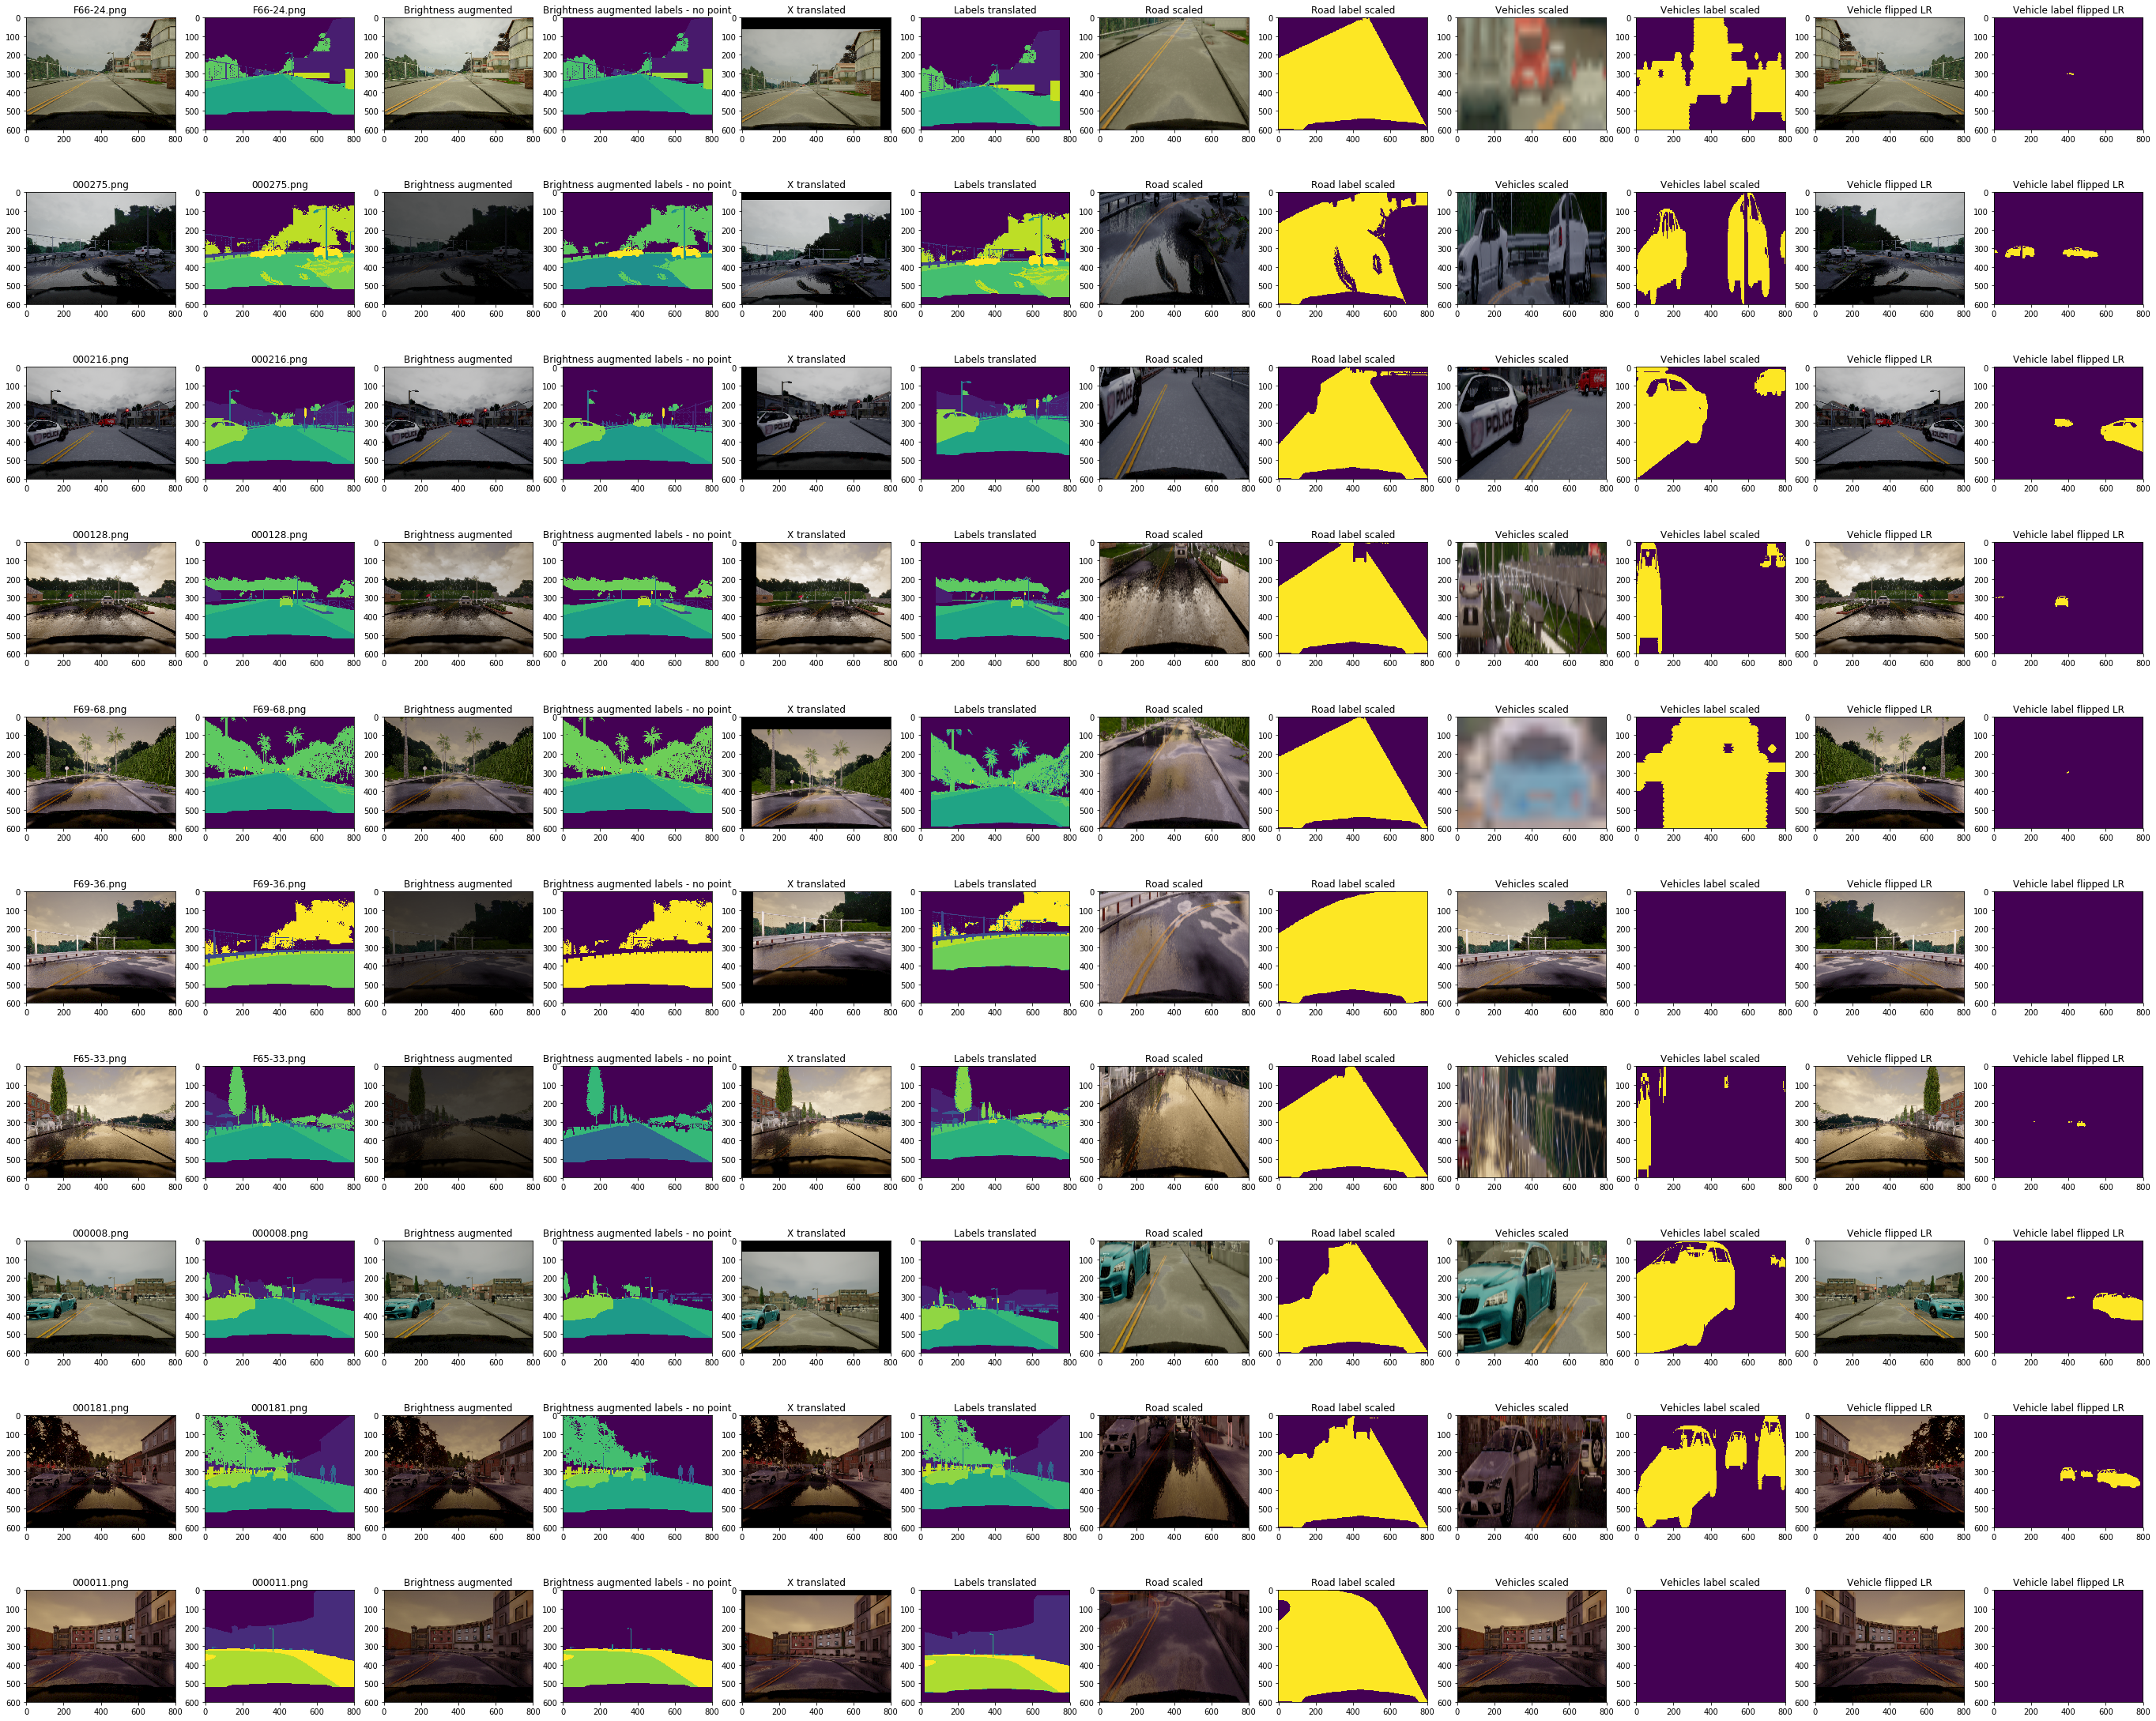

In [5]:
# Test augmentation
indices = (np.random.random(NUM_TO_SHOW) * len(X_paths)).astype(np.int32)
fig, axes = plt.subplots(NUM_TO_SHOW, 12, figsize=(48, 40))
for idx, indice in enumerate(indices):
    x_img = (mpimg.imread(X_paths[indice]) * 255).astype(np.uint8)
    y_img = (mpimg.imread(y_paths[indice]) * 255).astype(np.uint8)
    y_img = preprocess_labels(y_img)
    
    axes[idx,0].imshow(x_img)
    axes[idx,0].set_title(X_paths[indice].split("/")[-1])
    axes[idx,1].imshow(y_img[:,:,0])
    axes[idx,1].set_title(X_paths[indice].split("/")[-1])
    
    x_brightness, y_brightness = augment_brightness(x_img, y_img)
    axes[idx,2].imshow(x_brightness)
    axes[idx,2].set_title("Brightness augmented")
    axes[idx,3].imshow(y_brightness[:,:,0])
    axes[idx,3].set_title("Brightness augmented labels - no point")
    
    x_translated, y_translated = trans_image(x_img, y_img, 200)
    axes[idx,4].imshow(x_translated)
    axes[idx,4].set_title("X translated")
    axes[idx,5].imshow(y_translated[:,:,0])
    axes[idx,5].set_title("Labels translated")
    
    vehicles = relabel(y_img, 10)
    road = relabel(y_img, 7)
    x_stretched_road, y_stretched_road = rescale_to_bb(x_img, road)
    x_stretched_vehicles, y_stretched_vehicles = rescale_to_bb(x_img, vehicles)
    axes[idx,6].imshow(x_stretched_road)
    axes[idx,6].set_title("Road scaled")
    axes[idx,7].imshow(y_stretched_road[:,:,0])
    axes[idx,7].set_title("Road label scaled")
    axes[idx,8].imshow(x_stretched_vehicles)
    axes[idx,8].set_title("Vehicles scaled")
    axes[idx,9].imshow(y_stretched_vehicles[:,:,0])
    axes[idx,9].set_title("Vehicles label scaled")
    
    x_flipped, y_flipped = flip_lr(x_img, vehicles)
    axes[idx,10].imshow(x_flipped)
    axes[idx,10].set_title("Vehicle flipped LR")
    axes[idx,11].imshow(y_flipped[:,:,0])
    axes[idx,11].set_title("Vehicle label flipped LR")
    
plt.savefig(REPORT_FOLDER + "augmentation_visualization")

In [6]:
# Build dataset
from keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, X_paths, y_paths, target_label, batch_size=32, dim=(32,32), n_channels=1,
                 n_classes=10, shuffle=True, augmentation_factor=0):
        'Initialization'
        self.X_paths = X_paths
        self.y_paths = y_paths
        self.target_label = target_label
        self.dim = dim
        self.batch_size = batch_size
        self.dataset_size = len(self.X_paths)
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.augmentation_factor = augmentation_factor
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(self.dataset_size * (self.augmentation_factor * 3 + 1) / self.batch_size))

    # Index must be the batch number from 0 to len(self)
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        effective_batch_size = self.batch_size // ((self.augmentation_factor * 3) + 1)
        indexes = self.indexes[index*effective_batch_size:(index+1)*effective_batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(self.dataset_size)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=np.uint8)
        y = np.empty((self.batch_size, self.dim[0], self.dim[1], 1), dtype=np.float32)
        
        # Generate data
        for i, idx in enumerate(indices):
            xpath = self.X_paths[idx]
            ypath = self.y_paths[idx]
            x_img = (mpimg.imread(xpath) * 255).astype(np.uint8)
            y_img = (mpimg.imread(ypath) * 255).astype(np.uint8)
            
            y_img = preprocess_labels(y_img)
            relabeled = relabel(y_img, self.target_label)
            
            # Crop out the sky and hood
            x_img = x_img[200:520, :]
            relabeled = relabeled[200:520, :]

            # Store sample
            baseIdx = i*(self.augmentation_factor*3+1) 
            X[baseIdx,] = x_img
            y[baseIdx,] = np.reshape(relabeled[:,:,0], (relabeled.shape[0], relabeled.shape[1], 1))
            
            # augmentation
            for j in range(0, self.augmentation_factor):
                x_brightness, y_brightness = augment_brightness(x_img, relabeled)
                X[baseIdx + (j * 3) + 1,] = x_brightness
                y[baseIdx + (j * 3) + 1,] = np.reshape(relabeled[:,:,0], (relabeled.shape[0], relabeled.shape[1], 1))
                x_translated, y_translated = trans_image(x_img, relabeled, 200)
                X[baseIdx + (j * 3) + 2] = x_translated
                y[baseIdx + (j * 3) + 2] = np.reshape(y_translated[:,:,0], (relabeled.shape[0], relabeled.shape[1], 1))
                x_flipped, y_flipped = flip_lr(x_img, relabeled)
                X[baseIdx + (j * 3) + 3] = x_flipped
                y[baseIdx + (j * 3) + 3] = np.reshape(y_flipped[:,:,0], (relabeled.shape[0], relabeled.shape[1], 1))

        return X, y

## Test DataGenerator
Here we visualize and test the DataGenerator

Num of batches per epoch: 5197 
(20, 320, 800, 3) uint8 (20, 320, 800, 1) float32


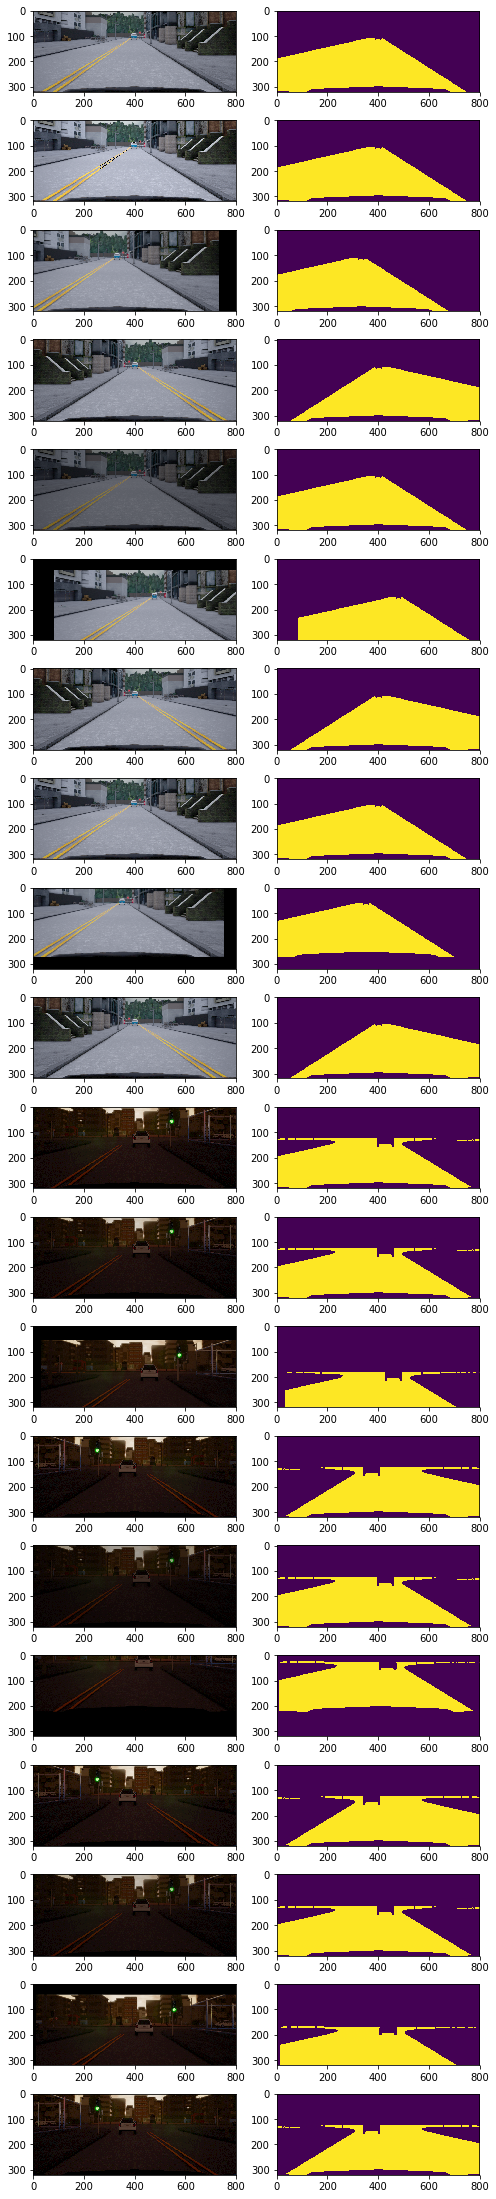

In [7]:
# Parameters
params = {'dim': (IMG_SIZE[0], IMG_SIZE[1]),
          'batch_size': 20,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True,
          'augmentation_factor': 3}
# Train road model
training_generator_vehicle = DataGenerator(X_paths, y_paths, 7, **params)
index = int(np.random.uniform(0,len(training_generator_vehicle)))
X_test_batch, y_test_batch = training_generator_vehicle[index]

print("Num of batches per epoch: %d " % len(training_generator_vehicle))
print(X_test_batch.shape, X_test_batch.dtype, y_test_batch.shape, y_test_batch.dtype)

# test data generated by generator
fig, axes = plt.subplots(params['batch_size'], 2, figsize=(8, params['batch_size'] * 2))
for idx in range(0, params['batch_size']):
    axes[idx,0].imshow(X_test_batch[idx,:,:,:])
    axes[idx,1].imshow(np.reshape(y_test_batch[idx,:,:,:], (y_test_batch.shape[1], y_test_batch.shape[2])))
    
plt.savefig(REPORT_FOLDER + "datagenerator_output")

In [8]:
import os 
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
from keras.models import *
from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, Reshape, Lambda
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K


smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


class Unet(object):

    def __init__(self, train, test, beta, size, model_filename, img_rows = 512, img_cols = 512, class_weight = None, num_epochs = 1):
        self.training_generator = train
        self.validation_generator = test
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.class_weight = class_weight
        self.num_epochs = num_epochs
        self.steps_per_epoch = None if train is None else len(train)
        self.model_filename = model_filename
        self.beta = beta
        self.size = size

    def load_data(self):
        pass

    def get_unet(self):

        inputs = Input((self.img_rows, self.img_cols, 3))
        norm = Lambda(lambda x: x/255)(inputs)

        conv1 = Conv2D(self.size * 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(norm)
        conv1 = Conv2D(self.size * 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

        conv2 = Conv2D(self.size * 32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
        conv2 = Conv2D(self.size * 32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

        conv3 = Conv2D(self.size * 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
        conv3 = Conv2D(self.size * 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

        conv4 = Conv2D(self.size * 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
        conv4 = Conv2D(self.size * 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
        drop4 = Dropout(0.5)(conv4)
        pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

        conv5 = Conv2D(self.size * 256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
        conv5 = Conv2D(self.size * 256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
        drop5 = Dropout(0.5)(conv5)

        up6 = Conv2D(self.size * 128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
        merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
        conv6 = Conv2D(self.size * 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
        conv6 = Conv2D(self.size * 128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
        
        up7 = Conv2D(self.size * 64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
        merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
        conv7 = Conv2D(self.size * 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
        conv7 = Conv2D(self.size * 64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

        up8 = Conv2D(self.size * 32, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
        merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
        conv8 = Conv2D(self.size * 32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
        conv8 = Conv2D(self.size * 32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

        up9 = Conv2D(self.size * 16, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
        merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
        conv9 = Conv2D(self.size * 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
        conv9 = Conv2D(self.size * 16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
        
        conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
        # conv10 = Reshape((conv10.get_shape()[1] * conv10.get_shape()[2], 1))(conv10)
        
        model = Model(inputs = inputs, outputs = conv10)

        # model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, sample_weight_mode = "temporal", metrics = [dice_coef])
        model.compile(optimizer = Adam(lr = 1e-4), loss = dice_coef_loss, metrics = [self.f2_score])
        # model.summary()
        
        return model


    # def train(self, force=True):
    #     model_checkpoint = ModelCheckpoint(self.model_filename, monitor='loss',verbose=1, save_best_only=True)
    #     try:
    #         self.model = load_model(self.model_filename, custom_objects={'dice_coef': dice_coef, 'loss': dice_coef_loss})
    #         if force:
    #             print('Training pre-existing model...')
    #             self.model.fit_generator(generator=self.training_generator,
    #                         validation_data=self.validation_generator,
    #                         use_multiprocessing=True,
    #                         workers=6, epochs=self.num_epochs, verbose=1, steps_per_epoch=self.steps_per_epoch,
    #                         callbacks=[model_checkpoint])
    #     except IOError as e:
    #         self.model = self.get_unet()
    #         print('Fitting model...')
    #         self.model.fit_generator(generator=self.training_generator,
    #                         validation_data=self.validation_generator,
    #                         use_multiprocessing=True,
    #                         workers=6, epochs=self.num_epochs, verbose=1, steps_per_epoch=self.steps_per_epoch,
    #                         callbacks=[model_checkpoint])

    def train(self, force=True):
        self.model = self.get_unet()
        model_checkpoint = ModelCheckpoint(self.model_filename, monitor='loss',verbose=1, save_best_only=True)
        if force:
            print('Training pre-existing model...')
            self.model.fit_generator(generator=self.training_generator,
                        validation_data=self.validation_generator,
                        use_multiprocessing=True,
                        workers=6, epochs=self.num_epochs, verbose=1, steps_per_epoch=self.steps_per_epoch,
                        callbacks=[model_checkpoint])
        else:
            try:
                self.model.load_weights(self.model_filename)
            except OSError as e:
                print('Fitting model...')
                self.model.fit_generator(generator=self.training_generator,
                                validation_data=self.validation_generator,
                                use_multiprocessing=True,
                                workers=6, epochs=self.num_epochs, verbose=1, steps_per_epoch=self.steps_per_epoch,
                                callbacks=[model_checkpoint])

    def precision(self, y_true_f, y_pred_f):
        tp = K.sum(y_true_f * y_pred_f)
        fp = K.sum(tf.cast(tf.logical_and(y_pred_f == 1, y_true_f == 0), tf.float32))
        return tp / (tp + fp) / 1.0

    def recall(self, y_true_f, y_pred_f):
        tp = K.sum(y_true_f * y_pred_f)
        fn = K.sum(tf.cast(tf.logical_and(y_pred_f == 0, y_true_f == 1), tf.float32))
        return tp / (tp + fn) / 1.0
        

    def f_score(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        p = self.precision(y_true_f, y_pred_f)
        r = self.recall(y_true, y_pred)
        return (1 + self.beta * self.beta) * (p * r) / (self.beta * self.beta * p + r)

    def f_loss(self, y_true, y_pred):
        return 1 - self.f_score(y_true, y_pred)

    def f2_score(self, y_true, y_pred):
        y_true = tf.cast(y_true, "int32")
        y_pred = tf.cast(tf.round(y_pred), "int32") # implicit 0.5 threshold via tf.round
        y_correct = y_true * y_pred
        sum_true = tf.reduce_sum(y_true, axis=1)
        sum_pred = tf.reduce_sum(y_pred, axis=1)
        sum_correct = tf.reduce_sum(y_correct, axis=1)
        precision = sum_correct / sum_pred
        recall = sum_correct / sum_true
        f_score = (1 + self.beta ** 2) * precision * recall / ((self.beta ** 2) * precision + recall)
        f_score = tf.where(tf.is_nan(f_score), tf.zeros_like(f_score), f_score)
        return tf.reduce_mean(f_score)



In [9]:
# Split into train and test datasets
from itertools import compress
FRACTION_TO_TRAIN = 0.8
msk = np.random.rand(len(X_paths)) < FRACTION_TO_TRAIN

X_paths_train = list(compress(X_paths, msk))
X_paths_test = list(compress(X_paths, ~msk))
y_paths_train = list(compress(y_paths, msk))
y_paths_test = list(compress(y_paths, ~msk))

print("Splitting into train and validation sets")
print(len(X_paths_train))
print(len(X_paths_test))
assert(len(set(X_paths_train).intersection(set(X_paths_test))) == 0)
assert(len(set(y_paths_train).intersection(set(y_paths_test))) == 0)


Splitting into train and validation sets
8376
2018


In [15]:
# Parameters
params = {'dim': (IMG_SIZE[0], IMG_SIZE[1]),
          'batch_size': 20,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}
num_epochs = 10
steps_per_epoch = int(len(X_paths_train)//params['batch_size'])
beta_road = 0.5
beta_vehicle = 2

# Train road model
training_generator_road = DataGenerator(X_paths_train, y_paths_train, 7, **params)
validation_generator_road = DataGenerator(X_paths_test, y_paths_test, 7, **params)
road_model = Unet(training_generator_road, validation_generator_road, beta_road, 1, "unet_small_road.hdf5", IMG_SIZE[0], IMG_SIZE[1], num_epochs=num_epochs)
road_model.train(force=False)

params = {'dim': (IMG_SIZE[0], IMG_SIZE[1]),
          'batch_size': 16,
          'n_classes': 2,
          'n_channels': 3,
          'shuffle': True}

# Train vehicle model
training_generator_vehicle = DataGenerator(X_paths_train, y_paths_train, 10, **params)
validation_generator_vehicle = DataGenerator(X_paths_test, y_paths_test, 10, **params)
vehicle_model = Unet(training_generator_vehicle, validation_generator_vehicle, beta_vehicle, 2, "unet_large_vehicle.hdf5", IMG_SIZE[0], IMG_SIZE[1], num_epochs=num_epochs)
vehicle_model.train(force=False)

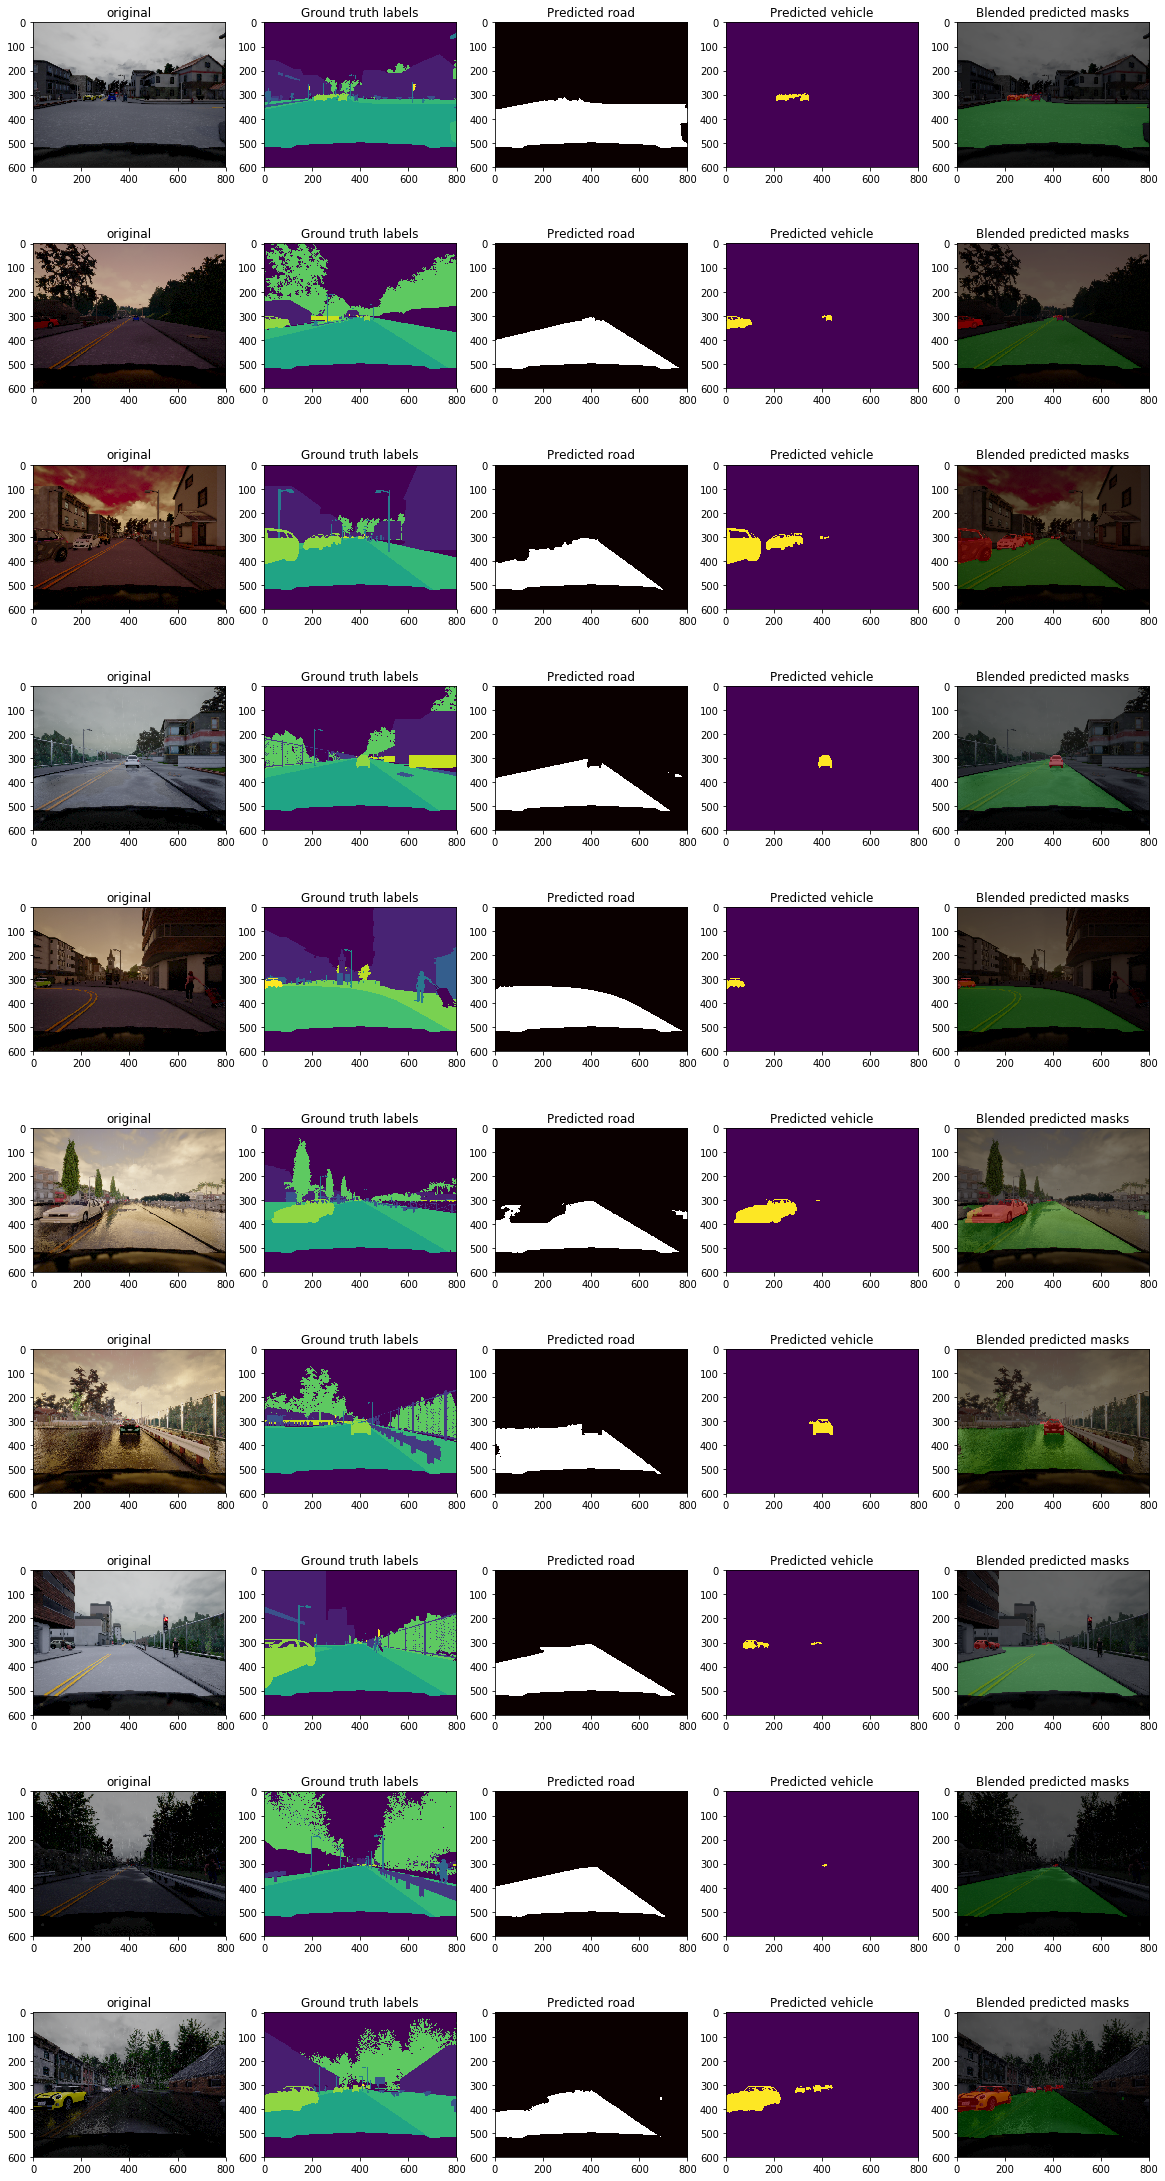

In [16]:
# Test predictions
OUTPUT_FOLDER = "./output_images/"
NUM_TO_SHOW = 10
count = 0
fig, axes = plt.subplots(NUM_TO_SHOW, 5, figsize=(20, 4 * NUM_TO_SHOW))
indices = (np.random.random(NUM_TO_SHOW) * len(X_paths_test)).astype(np.int32)
for index, indice in enumerate(indices):
    frame = X_paths_test[indice]
    x_img = (mpimg.imread(X_paths_test[indice]) * 255).astype(np.uint8)
    y_img = (mpimg.imread(y_paths_test[indice]) * 255).astype(np.uint8)
    y_img = preprocess_labels(y_img)
    y_img_road = relabel(y_img, 7)
    y_img_vehicle = relabel(y_img, 10)
    
    # original
    axes[index, 0].imshow(x_img)
    axes[index, 0].set_title("original")
    
    # Ground truth labels
    axes[index, 1].imshow(y_img[:,:,0])
    axes[index, 1].set_title("Ground truth labels")
    
    # Predicted road
    img = x_img[200:520,]
    img_to_predict = np.reshape(img, (1, IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
    yhat_road = road_model.model.predict(img_to_predict)
    yhat_road = np.where(yhat_road > 0.90, 1, 0)
    yhat_road_final = np.zeros((1, 600, 800,1))
    yhat_road_final[0,200:520,:,] = yhat_road
    axes[index, 2].imshow(yhat_road_final[0,:,:,0], cmap='hot')
    axes[index, 2].set_title("Predicted road")
    
    # Predicted vehicle
    yhat_vehicle = vehicle_model.model.predict(img_to_predict)
    yhat_vehicle = np.where(yhat_vehicle > 0.10, 1, 0)
    yhat_vehicle_final = np.zeros((1, 600, 800, 1))
    yhat_vehicle_final[0,200:520,:,] = yhat_vehicle
    axes[index, 3].imshow(yhat_vehicle_final[0,:,:,0])
    axes[index, 3].set_title("Predicted vehicle")
    
    zero_channel = np.zeros((600, 800, 1)).astype(np.uint8)
    
    # Blend - road will be green, vehicle will be red
    mask_road = np.concatenate((
        zero_channel,
        np.reshape((yhat_road_final[0,:,:,0] * 255).astype(np.uint8), (600, 800, 1)),
        zero_channel
    ), axis=2)
    
    mask_vehicle = np.concatenate((
        np.reshape((yhat_vehicle_final[0,:,:,0] * 255).astype(np.uint8), (600, 800, 1)),
        zero_channel,
        zero_channel
    ), axis=2)
    
    blended = cv2.addWeighted(x_img, 0.7, mask_road, 0.3, 0)
    blended = cv2.addWeighted(blended, 0.7, mask_vehicle, 0.3, 0)
    mpimg.imsave(OUTPUT_FOLDER + "image_segmented_" + frame.split("/")[-1], blended)
    axes[index,4].imshow(blended)
    axes[index,4].set_title("Blended predicted masks")

plt.savefig(REPORT_FOLDER + "unet_output_visualization")

In [17]:
def process_frame(frame):
    # predict
    cropped = frame[200:520,]
    img_to_predict = np.reshape(cropped, (1, IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
    yhat_road = road_model.model.predict(img_to_predict)
    yhat_vehicle = vehicle_model.model.predict(img_to_predict)

    # binarize
    yhat_road_final = np.zeros((600, 800, 1))
    yhat_vehicle_final = np.zeros((600, 800, 1))
    
    yhat_road = np.where(yhat_road > 0.99, 1, 0).astype('uint8')
    yhat_vehicle = np.where(yhat_vehicle > 0.1, 1, 0).astype('uint8')
    
    yhat_road_final[200:520,:,] = yhat_road
    yhat_vehicle_final[200:520,:,] = yhat_vehicle
    
    zero_channel = np.zeros((600, 800, 1)).astype(np.uint8)
    
    # Blend - road will be green, vehicle will be red
    mask_road = np.concatenate((
        zero_channel,
        np.reshape((yhat_road_final[:,:,0] * 255).astype(np.uint8), (600, 800, 1)),
        zero_channel
    ), axis=2)
    
    mask_vehicle = np.concatenate((
        np.reshape((yhat_vehicle_final[:,:,0] * 255).astype(np.uint8), (600, 800, 1)),
        zero_channel,
        zero_channel
    ), axis=2)
    

    blended = cv2.addWeighted(frame.astype('uint8'), 0.7, mask_road, 0.3, 0)
    blended = cv2.addWeighted(blended, 0.7, mask_vehicle, 0.3, 0)
    blended = cv2.resize(blended, (800, 600))

    return blended

In [37]:
#  returns binary arrays for grading
def process_frame_for_grading(frame, road_model, vehicle_model, road_threshold, vehicle_threshold):
    # predict
    cropped = frame[START_Y:END_Y,:]
    img_to_predict = np.reshape(cropped, (1, IMG_SIZE[0], IMG_SIZE[1], IMG_SIZE[2]))
    
    # t0 = time.time()
    yhat_road = road_model.model.predict(img_to_predict)
    # t1 = time.time()
    yhat_vehicle = vehicle_model.model.predict(img_to_predict)
    # t2 = time.time()

    # print("Time taken to predict road: %.3fms" % ((t1-t0) * 1000.0))
    # print("Time taken to predict vehicle: %.3fms" % ((t2 - t1) * 1000.0))
    
    # binarize
    binary_road_result = np.zeros((600, 800)).astype('uint8')
    binary_car_result = np.zeros((600, 800)).astype('uint8')
    binary_cropped_road = np.where(yhat_road > road_threshold, 1, 0).astype('uint8')
    binary_cropped_vehicle = np.where(yhat_vehicle > vehicle_threshold, 1, 0).astype('uint8')
    
    overlap = np.where((binary_cropped_vehicle == 1) & (binary_cropped_road == 1))
    binary_cropped_vehicle[overlap] = 1
    binary_cropped_road[overlap] = 0

    binary_road_result[START_Y:END_Y, :] = binary_cropped_road[0,:,:,0]
    binary_car_result[START_Y:END_Y, :] = binary_cropped_vehicle[0,:,:,0]
    return binary_car_result, binary_road_result

ans_data  = {}
student_ans_data = {}
frame = 1
EPISODE_NUM = "town02_episode_0012_train"
file_list_x = glob.glob("./%s/CameraRGB/*.png" % EPISODE_NUM)
file_list_y = glob.glob("./%s/CameraSeg/*.png" % EPISODE_NUM)
for xpath, ypath in zip(file_list_x[1:100], file_list_y[1:100]):
    rgb_frame = (mpimg.imread(xpath) * 255).astype(np.uint8)
    y_img = (mpimg.imread(ypath) * 255).astype(np.uint8)
    y_img = preprocess_labels(y_img)
    vehicle = relabel(y_img, 10)
    road = relabel(y_img, 7)
    binary_car_result, binary_road_result = process_frame_for_grading(rgb_frame, road_model,
                                                                      vehicle_model, 0.90, 0.99)
    student_ans_data[frame] = [binary_car_result, binary_road_result]
    ans_data[frame] = [vehicle[:,:,0], road[:,:,0]]
    frame += 1


In [38]:
# Scoring function

import sys
import json
import base64
import numpy as np
from scipy import misc

frames_processed = 0

Car_TP = 0 # True Positives
Car_FP = 0 # Flase Positives
Car_TN = 0 # True Negatives
Car_FN = 0 # True Negatives

Road_TP = 0 # True Positives
Road_FP = 0 # Flase Positives
Road_TN = 0 # True Negatives
Road_FN = 0 # True Negatives

Road_Car_Overlap = 0

for frame in range(1,len(ans_data.keys())+1):

    truth_data_car =  ans_data[frame][0]
    truth_data_road =  ans_data[frame][1]
    student_data_car = student_ans_data[frame][0]
    student_data_road = student_ans_data[frame][1]
    
    Road_Car_Overlap += np.sum(np.logical_and(student_data_car == 1, student_data_road == 1))

    Car_TP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 1))
    Car_FP += np.sum(np.logical_and(student_data_car == 1, truth_data_car == 0))
    Car_TN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 0))
    Car_FN += np.sum(np.logical_and(student_data_car == 0, truth_data_car == 1))

    Road_TP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 1))
    Road_FP += np.sum(np.logical_and(student_data_road == 1, truth_data_road == 0))
    Road_TN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 0))
    Road_FN += np.sum(np.logical_and(student_data_road == 0, truth_data_road == 1))

    frames_processed+=1


# Generate results
print("CAR:")
print("TP: %.7d, FP: %.7d, FN: %.7d" % (Car_TP, Car_FP, Car_FN))
print()
print("ROAD:")
print("TP: %.7d, FP: %.7d, FN: %.7d" % (Road_TP, Road_FP, Road_FN))
print()
print("Overlap: %.7d" % (Road_Car_Overlap))

Car_precision = Car_TP/(Car_TP+Car_FP)/1.0
Car_recall = Car_TP/(Car_TP+Car_FN)/1.0
Car_beta = 2
Car_F = (1+Car_beta**2) * ((Car_precision*Car_recall)/(Car_beta**2 * Car_precision + Car_recall))
Road_precision = Road_TP/(Road_TP+Road_FP)/1.0
Road_recall = Road_TP/(Road_TP+Road_FN)/1.0
Road_beta = 0.5
Road_F = (1+Road_beta**2) * ((Road_precision*Road_recall)/(Road_beta**2 * Road_precision + Road_recall))

print ("Car F score: %05.3f  | Car Precision: %05.3f  | Car Recall: %05.3f  |\n\
Road F score: %05.3f | Road Precision: %05.3f | Road Recall: %05.3f | \n\
Averaged F score: %05.3f" %(Car_F,Car_precision,Car_recall,Road_F,Road_precision,Road_recall,((Car_F+Road_F)/2.0)))



CAR:
TP: 0301737, FP: 0036697, FN: 0280134

ROAD:
TP: 8864506, FP: 0204898, FN: 1339415

Overlap: 0000000
Car F score: 0.566  | Car Precision: 0.892  | Car Recall: 0.519  |
Road F score: 0.954 | Road Precision: 0.977 | Road Recall: 0.869 | 
Averaged F score: 0.760


In [20]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_out_file = 'actual_video_out.mp4'
clip_test = VideoFileClip('actual_test_video.mp4')
clip_test_out = clip_test.fl_image(process_frame)
%time clip_test_out.write_videofile(project_out_file, audio=False)

[MoviePy] >>>> Building video actual_video_out.mp4
[MoviePy] Writing video actual_video_out.mp4


100%|█████████▉| 1000/1001 [1:40:42<00:06,  6.04s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: actual_video_out.mp4 

CPU times: user 3h 28min 10s, sys: 59min 39s, total: 4h 27min 50s
Wall time: 1h 40min 43s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_out_file))

In [43]:
EPISODE_NUM = "episode_0012_train"
OUTPUT_VIDEO = "./output_video/"
OUTPUT_VIDEO_FRAME = "./output_video_frame"
file_list_x = glob.glob("./train/%s/CameraRGB/*.png" % EPISODE_NUM)
file_list_y = glob.glob("./train/%s/CameraSeg/*.png" % EPISODE_NUM)
for idx, (x, y) in enumerate(zip(file_list_x, file_list_y)):
    filename = x.split("/")[-1]
    x_img = (mpimg.imread(x) * 255).astype(np.uint8)
    # y_img = (mpimg.imread(y) * 255).astype(np.uint8)
    result = process_frame(x_img)
    mpimg.imsave("%s/%s/%s" % (OUTPUT_VIDEO_FRAME, EPISODE_NUM, filename), (result/255).astype(np.float32))

In [44]:
from moviepy.editor import *
import os

fps = 12

file_list = glob.glob('%s/%s/*.png' % (OUTPUT_VIDEO_FRAME, EPISODE_NUM))  # Get all the pngs in the ouput directory

clips = [ImageClip(m).set_duration(1/fps) for m in file_list]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("%s/%s_video.mp4" % (OUTPUT_VIDEO, EPISODE_NUM), fps=fps)

[MoviePy] >>>> Building video ./output_video//episode_0012_train_video.mp4
[MoviePy] Writing video ./output_video//episode_0012_train_video.mp4


100%|██████████| 300/300 [00:24<00:00, 11.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_video//episode_0012_train_video.mp4 

